# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

**Студент - Дмитрий Лялин**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

Так. Сначала посмотрим на наши данные

In [ ]:
df.shape

(3755, 11)

In [ ]:
df.head(2)

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   

  company_location company_size  
0               ES            L  
1               US            S

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
df.describe(exclude='number')

experience_level employment_type      job_title salary_currency  \
count              3755            3755           3755            3755   
unique                4               4             93              20   
top                  SE              FT  Data Engineer             USD   
freq               2516            3718           1040            3224   

       employee_residence company_location company_size  
count                3755             3755         3755  
unique                 78               72            3  
top                    US               US            M  
freq                 3004             3040         3153

Колонка remote_ratio - дискретная числовая, но можно назвать ее и категориальной с 3-мя категориями (работа удаленная, в офисе и гибрид).

In [ ]:
cat_cols = list(df.describe(exclude='number').columns) + ['remote_ratio']
cat_cols

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size',
 'remote_ratio']

In [ ]:
category_values = {col: set(df[col].unique()) for col in cat_cols}

In [ ]:
our_categories = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'remote_ratio': [0, 50, 100],
    'company_size': ['S', 'M', 'L']
}

In [ ]:
for column, valid_set in our_categories.items():
    actual_values = category_values.get(column, set())
    invalid_values = actual_values - set(valid_set)
    if invalid_values:
        print(f'В колонке {column} найдены лишние значения: {invalid_values}')
    else:
        print(f'Все ок с колонкой {column}')

Все ок с колонкой experience_level
Все ок с колонкой employment_type
Все ок с колонкой remote_ratio
Все ок с колонкой company_size


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

Посмотрим на пропуски

In [ ]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Их нет. Все ок. Теперь очередь за дубликатами

In [ ]:
df.duplicated().sum()

1171

Ого как много. Надо их удалить

In [ ]:
df = df.drop_duplicates()
df.shape

(2584, 11)

Теперь поищем, например, отрицательные числовые значения

In [ ]:
numeric_columns = df.select_dtypes(include=['number'])
numeric_columns.head()

work_year  salary  salary_in_usd  remote_ratio
0       2023   80000          85847           100
1       2023   30000          30000           100
2       2023   25500          25500           100
3       2023  175000         175000           100
4       2023  120000         120000           100

In [ ]:
(numeric_columns < 0).sum()

work_year        0
salary           0
salary_in_usd    0
remote_ratio     0
dtype: int64

Отрицательных нет. Отлично. Едем дальше.

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [ ]:
unique_counts = df.nunique()
unique_counts

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

**Ваши выводы здесь**  
* Очень много признаков в job_title, employee_residence	и company_location.
Все ли признаки нам нужны для прогнозирования зарплат? Трудно сказать, фиче импортанс подскажет. Но на глаз все могут понадобиться.  
* Что касается релевантности признаков, то я бы удалил salary, так как это очевидный лик для любой сильной модели. Но следующие задания просят обучить линейную регрессию на числовых признаках, если удалим salary, то не на чем будет обучать (останется год и наличие удаленки (0, 50, 100)), по ним очевидно зарплату не предскажешь. Поэтому в качестве учебной домашки не будем трогать salary.

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=777)

In [ ]:
train.shape, test.shape

((2067, 11), (517, 11))

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

Ремарка. Конечно же непрерывным признаком в этом датасете является salary и salary_in_usd (очевидно, наш таргет). Но так как мы будем строить линейную регрессию в следующем задании на числовых признаках, то оставим порядковый числовой признак work_year и дискретный remote_ratio. Линейной регрессии сойдет.

In [ ]:
num_cols = list(train.select_dtypes(include=['number']).columns)
num_cols.remove('salary_in_usd')
num_cols

['work_year', 'salary', 'remote_ratio']

Теперь переопределим cat_cols, раз уж remote_ratio мы поместили выше.

In [ ]:
cat_cols = list(train.describe(exclude='number').columns)
cat_cols

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

In [ ]:
X_train_num = train[num_cols]
y_train = train['salary_in_usd']
X_test_num = test[num_cols]
y_test = test['salary_in_usd']
X_train_full = train.drop(columns=['salary_in_usd'])
X_test_full = test.drop(columns=['salary_in_usd'])
X_train_num.shape, y_train.shape, X_test_num.shape, y_test.shape, X_train_full.shape, X_test_full.shape

((2067, 3), (2067,), (517, 3), (517,), (2067, 10), (517, 10))

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train_num, y_train)

LinearRegression()

In [ ]:
y_pred_lr = model_lr.predict(X_test_num)
mape_lr = mape(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse(y_test, y_pred_lr))
mape_lr, rmse_lr

(0.8590495296439182, 66703.81711210212)

Процентная ошибка 0.859 (почти 86%). На первый взгляд не густо.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model_cat = CatBoostRegressor(verbose=0)
model_cat.fit(X_train_num, y_train)

In [ ]:
y_pred_cat = model_cat.predict(X_test_num)
mape_cat = mape(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse(y_test, y_pred_cat))
mape_cat, rmse_cat

(0.36509850705975094, 26765.334670324533)

О. Как будто значительно лучше чем линейная регрессия.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder

In [ ]:
num_cols

['work_year', 'salary', 'remote_ratio']

In [ ]:
cat_cols

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

OHE

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(train[cat_cols])
X_test_ohe = ohe.transform(test[cat_cols])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(cat_cols), index=train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(cat_cols), index=test.index)
X_train_ohe = pd.concat([train[num_cols], X_train_ohe], axis=1)
X_test_ohe = pd.concat([test[num_cols], X_test_ohe], axis=1)

In [ ]:
X_train_ohe.shape, X_test_ohe.shape

((2067, 262), (517, 262))

In [ ]:
model_lr_ohe = LinearRegression()
model_cat_ohe = CatBoostRegressor(verbose=0, random_state=777)
model_lr_ohe.fit(X_train_ohe, y_train)
model_cat_ohe.fit(X_train_ohe, y_train);

In [ ]:
y_pred_lr_ohe = model_lr_ohe.predict(X_test_ohe)
y_pred_cat_ohe = model_cat_ohe.predict(X_test_ohe)
mape_lr_ohe = mape(y_test, y_pred_lr_ohe)
rmse_lr_ohe = np.sqrt(mse(y_test, y_pred_lr_ohe))
mape_cat_ohe = mape(y_test, y_pred_cat_ohe)
rmse_cat_ohe = np.sqrt(mse(y_test, y_pred_cat_ohe))

Label

In [ ]:
X_train_label = train[cat_cols].apply(LabelEncoder().fit_transform)
X_test_label = test[cat_cols].apply(LabelEncoder().fit_transform)
X_train_label = pd.concat([train[num_cols], X_train_label], axis=1)
X_test_label = pd.concat([test[num_cols], X_test_label], axis=1)

In [ ]:
model_lr_label = LinearRegression()
model_cat_label = CatBoostRegressor(verbose=0, random_state=777)
model_lr_label.fit(X_train_label, y_train)
model_cat_label.fit(X_train_label, y_train);

In [ ]:
y_pred_lr_label = model_lr_label.predict(X_test_label)
y_pred_cat_label = model_cat_label.predict(X_test_label)
mape_lr_label = mape(y_test, y_pred_lr_label)
rmse_lr_label = np.sqrt(mse(y_test, y_pred_lr_label,))
mape_cat_label = mape(y_test, y_pred_cat_label)
rmse_cat_label = np.sqrt(mse(y_test, y_pred_cat_label))

MTE

In [ ]:
te = TargetEncoder()
X_train_te = te.fit_transform(train[cat_cols], y_train)
X_test_te = te.transform(test[cat_cols])
X_train_te = pd.concat([train[num_cols], X_train_te], axis=1)
X_test_te = pd.concat([test[num_cols], X_test_te], axis=1)

In [ ]:
model_lr_te = LinearRegression()
model_cat_te = CatBoostRegressor(verbose=0, random_state=777)
model_lr_te.fit(X_train_te, y_train)
model_cat_te.fit(X_train_te, y_train);

In [ ]:
y_pred_lr_te = model_lr_te.predict(X_test_te)
y_pred_cat_te = model_cat_te.predict(X_test_te)
mape_lr_te = mape(y_test, y_pred_lr_te)
rmse_lr_te = np.sqrt(mse(y_test, y_pred_lr_te))
mape_cat_te = mape(y_test, y_pred_cat_te)
rmse_cat_te = np.sqrt(mse(y_test, y_pred_cat_te))

In [ ]:
results_encoders_metrics = pd.DataFrame({
    "Encoding Strategy": ["OHE", "OHE", "Label Encoding", "Label Encoding", "Mean Target Encoding", "Mean Target Encoding"],
    "Model": ["Linear Regression", "CatBoost", "Linear Regression", "CatBoost", "Linear Regression", "CatBoost"],
    "MAPE": [mape_lr_ohe, mape_cat_ohe, mape_lr_label, mape_cat_label, mape_lr_te, mape_cat_te],
    "RMSE": [rmse_lr_ohe, rmse_cat_ohe, rmse_lr_label, rmse_cat_label, rmse_lr_te, rmse_cat_te]
})
results_encoders_metrics

Encoding Strategy              Model      MAPE          RMSE
0                   OHE  Linear Regression  0.595042  72408.939211
1                   OHE           CatBoost  0.074801   6269.894243
2        Label Encoding  Linear Regression  0.492075  72750.902552
3        Label Encoding           CatBoost  0.518428  68002.614114
4  Mean Target Encoding  Linear Regression  0.488055  53042.614185
5  Mean Target Encoding           CatBoost  0.110028  11325.625412

Ого. Неожиданно. Лейбл энкодинг очень плох для катбуста. А победил catboost с OHE и 200+ колонками. Хорошо, что у нас не 2 млн строк =)

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
y_pred_cat_ohe[:10]

array([162186.42288207, 126575.36598117, 115570.8982042 , 139533.63785983,
        66526.01555419, 220519.31678737,  90522.92643301,  97718.37714969,
       160425.90213636,  70948.09262796])

In [ ]:
errors_cat_ohe = abs(y_test - y_pred_cat_ohe)

error_cat_ohe_df = pd.DataFrame({
    "Actual Salary": y_test.values,
    "Predicted Salary": y_pred_cat_ohe,
    "Absolute Error": errors_cat_ohe
}, index=y_test.index)
error_cat_ohe_df = test.merge(error_cat_ohe_df, left_index=True, right_index=True)

In [ ]:
top_20_errors_cat_ohe = error_cat_ohe_df.sort_values(by="Absolute Error", ascending=False).head(20)
top_20_errors_cat_ohe

work_year experience_level employment_type                   job_title  \
2684       2022               MI              FT                NLP Engineer   
3669       2021               MI              FT              Data Scientist   
3634       2021               MI              FT               Data Engineer   
3420       2022               EX              FT    Director of Data Science   
2834       2021               EN              FT  Machine Learning Developer   
3683       2020               SE              FT           Big Data Engineer   
2555       2022               SE              FT              Data Architect   
2872       2022               EN              FT                Data Analyst   
1288       2023               SE              FT                Data Analyst   
2578       2021               EN              FT          Power BI Developer   
2374       2022               SE              FT              Data Scientist   
1421       2023               SE              FT           Applied Scientist   
3725       2021               SE              FT    Principal Data Scientist   
3468       2022               SE              FT      Applied Data Scientist   
3750       2020               SE              FT              Data Scientist   
1087       2023               SE              FT   Machine Learning Engineer   
3667       2021               MI              FT              Data Scientist   
114        2022               EN              FT   Machine Learning Engineer   
2654       2022               MI              FT              Data Scientist   
3492       2021               EN              FT   Machine Learning Engineer   

        salary salary_currency  salary_in_usd employee_residence  \
2684    120000             CZK           5132                 CZ   
3669  30400000             CLP          40038                 CL   
3634    250000             TRY          28016                 TR   
3420    250000             CAD         192037                 CA   
2834     15000             USD          15000                 TH   
3683    100000             EUR         114047                 PL   
2555    345600             USD         345600                 US   
2872    500000             INR           6359                 FR   
1288    385000             USD         385000                 US   
2578    400000             INR           5409                 IN   
2374    350000             USD         350000                 US   
1421    350000             USD         350000                 US   
3725    147000             EUR         173762                 DE   
3468    380000             USD         380000                 US   
3750    412000             USD         412000                 US   
1087    269000             USD         269000                 CA   
3667    420000             INR           5679                 IN   
114      54000             CHF          56536                 CH   
2654    120000             AUD          83171                 AU   
3492     20000             USD          20000                 IN   

      remote_ratio company_location company_size  Actual Salary  \
2684           100               CZ            M           5132   
3669           100               CL            L          40038   
3634           100               TR            M          28016   
3420            50               CA            L         192037   
2834           100               TH            L          15000   
3683           100               GB            S         114047   
2555             0               US            M         345600   
2872           100               IN            L           6359   
1288             0               US            M         385000   
2578            50               IN            L           5409   
2374           100               US            M         350000   
1421             0               US            L         350000   
3725           100       

**Ваш ответ здесь**.  
Где ошибается:
* Редкие профессии (Head of Data, Director of Data Science) - сильные отклонения.
* Нестандартные валюты и регионы (INR, TRY, HUF) - большие ошибки.
* Экстремальные зарплаты (очень высокие/низкие) - модель недооценивает.

Как улучшить?
* Логарифмировать зарплату (np.log(salary_in_usd)) для уменьшения влияния выбросов.
* Группировать валюты и профессии (например, редкие роли объединить).
* Пробовать Target Encoding вместо OHE/Label Encoding.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
train["is_executive"] = train["job_title"].str.contains("Lead|Director|Head").astype(int)
test["is_executive"] = test["job_title"].str.contains("Lead|Director|Head").astype(int)

In [ ]:
cat_cols

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

In [ ]:
X_train_ohe_feature = pd.concat([X_train_ohe, train["is_executive"]], axis=1)
X_test_ohe_feature = pd.concat([X_test_ohe, test["is_executive"]], axis=1)

In [ ]:
model_cat_feature = CatBoostRegressor(verbose=0, random_state=777)
model_cat_feature.fit(X_train_ohe_feature, y_train_log)
y_pred_log = model_cat_feature.predict(X_test_ohe_feature)

In [ ]:
y_pred_log[:5]

array([12.00574324, 11.75380072, 11.67168426, 11.83987133, 11.11068161])

In [ ]:
y_pred_un_log = np.expm1(y_pred_log)
mape_cat_feature = mape(y_test, y_pred_un_log)
rmse_cat_feature = np.sqrt(mse(y_test, y_pred_un_log))
mape_cat_feature, rmse_cat_feature

(0.06388806618563862, 6419.015814688837)

In [ ]:
results_encoders_metrics

Encoding Strategy              Model      MAPE          RMSE
0                   OHE  Linear Regression  0.595042  72408.939211
1                   OHE           CatBoost  0.077727   5862.883205
2        Label Encoding  Linear Regression  0.492075  72750.902552
3        Label Encoding           CatBoost  0.620521  70171.758837
4  Mean Target Encoding  Linear Regression  0.488055  53042.614185
5  Mean Target Encoding           CatBoost  0.119563  12291.801229

In [ ]:
new_result = pd.DataFrame({
    "Encoding Strategy": ["OHE"],
    "Model": ["CatBoost_new_feature"],
    "MAPE": [mape_cat_feature],
    "RMSE": [rmse_cat_feature]
})

results_encoders_metrics = pd.concat([results_encoders_metrics, new_result], ignore_index=True)
results_encoders_metrics

Encoding Strategy                 Model      MAPE          RMSE
0                   OHE     Linear Regression  0.595042  72408.939211
1                   OHE              CatBoost  0.074801   6269.894243
2        Label Encoding     Linear Regression  0.492075  72750.902552
3        Label Encoding              CatBoost  0.518428  68002.614114
4  Mean Target Encoding     Linear Regression  0.488055  53042.614185
5  Mean Target Encoding              CatBoost  0.110028  11325.625412
6                   OHE  CatBoost_new_feature  0.063888   6419.015815

**Ваш ответ здесь**.  
Очень интересно. Mape уменьшилась, а RMSE выросла.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import time

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "random_seed": 777,
        "verbose": 0
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_ohe, y_train)
    y_pred = model.predict(X_test_ohe)
    return mape(y_test, y_pred)

In [ ]:
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
end_time = time.time()
print(f"Лучшие параметры: {best_params}")
print(f"Время подбора гиперпараметров: {end_time - start_time:.2f} секунд")

Лучшие параметры: {'iterations': 1510, 'depth': 8, 'learning_rate': 0.17132387538835908, 'l2_leaf_reg': 9, 'border_count': 111}
Время подбора гиперпараметров: 525.70 секунд


In [ ]:
start_train = time.time()
final_cat_model = CatBoostRegressor(**best_params, verbose=0, random_seed=777)
final_cat_model.fit(X_train_ohe, y_train)
end_train = time.time()
start_pred = time.time()
y_pred_final = final_cat_model.predict(X_test_ohe)
end_pred = time.time()

In [ ]:
mape_final_cat = mape(y_test, y_pred_final)
rmse_final_cat = np.sqrt(mse(y_test, y_pred_final))

print(f"MAPE (CatBoost + Optuna): {mape_final_cat:.4f}")
print(f"RMSE (CatBoost + Optuna): {rmse_final_cat:.2f}")
print(f"Время обучения финальной модели: {end_train - start_train:.2f} секунд")
print(f"Время предсказания: {end_pred - start_pred:.5f} секунд")

MAPE (CatBoost + Optuna): 0.0739
RMSE (CatBoost + Optuna): 7485.13
Время обучения финальной модели: 5.03 секунд
Время предсказания: 0.00791 секунд


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
import xgboost as xgb

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 777,
        "verbosity": 0
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_ohe, y_train)
    y_pred = model.predict(X_test_ohe)

    return mape(y_test, y_pred)

In [ ]:
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
end_time = time.time()
print(f"Лучшие параметры: {best_params}")
print(f"Время подбора гиперпараметров: {end_time - start_time:.2f} секунд")

Лучшие параметры: {'n_estimators': 1032, 'max_depth': 7, 'learning_rate': 0.1069686913542428, 'reg_lambda': 8.442046320766625, 'reg_alpha': 3.7829399996360005, 'subsample': 0.9015286427154874, 'colsample_bytree': 0.9967744092276221}
Время подбора гиперпараметров: 431.57 секунд


In [ ]:
start_train = time.time()
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(X_train_ohe, y_train)
end_train = time.time()
start_pred = time.time()
y_pred_final = final_xgb_model.predict(X_test_ohe)
end_pred = time.time()

In [ ]:
mape_final_xgb = mape(y_test, y_pred_final)
rmse_final_xgb = np.sqrt(mse(y_test, y_pred_final))

print(f"MAPE (XGBoost + Optuna): {mape_final_xgb:.4f}")
print(f"RMSE (XGBoost + Optuna): {rmse_final_xgb:.2f}")
print(f"Время обучения финальной модели: {end_train - start_train:.2f} секунд")
print(f"Время предсказания: {end_pred - start_pred:.5f} секунд")

MAPE (XGBoost + Optuna): 0.0701
RMSE (XGBoost + Optuna): 5730.32
Время обучения финальной модели: 2.56 секунд
Время предсказания: 0.06265 секунд


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
pip install lightgbm -q

In [ ]:
import lightgbm as lgb

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "random_state": 777,
        "verbosity": -1
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_ohe, y_train)
    y_pred = model.predict(X_test_ohe)

    return mape(y_test, y_pred)

In [ ]:
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
end_time = time.time()

print(f"Лучшие параметры: {best_params}")
print(f"Время подбора гиперпараметров: {end_time - start_time:.2f} секунд")

Лучшие параметры: {'n_estimators': 562, 'max_depth': 9, 'learning_rate': 0.08406359132731824, 'lambda_l1': 0.3475830965797472, 'lambda_l2': 0.34161983932154927, 'bagging_fraction': 0.6696098338335468, 'feature_fraction': 0.9838504591261364}
Время подбора гиперпараметров: 60.43 секунд


In [ ]:
start_train = time.time()
final_lgbm_model = lgb.LGBMRegressor(**best_params)
final_lgbm_model.fit(X_train_ohe, y_train)
end_train = time.time()
start_pred = time.time()
y_pred_final = final_lgbm_model.predict(X_test_ohe)
end_pred = time.time()

In [ ]:
mape_final_lgb = mape(y_test, y_pred_final)
rmse_final_lgb = np.sqrt(mse(y_test, y_pred_final))

print(f"MAPE (LightGBM + Optuna): {mape_final_lgb:.4f}")
print(f"RMSE (LightGBM + Optuna): {rmse_final_lgb:.2f}")
print(f"Время обучения финальной модели: {end_train - start_train:.2f} секунд")
print(f"Время предсказания: {end_pred - start_pred:.5f} секунд")

MAPE (LightGBM + Optuna): 0.0699
RMSE (LightGBM + Optuna): 7092.72
Время обучения финальной модели: 0.30 секунд
Время предсказания: 0.02986 секунд


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

Выводы:  
* Какая из моделей показала лучший результат по качеству? - Лучшая по mape модель - это lightgbm на нашем датасете с OHE (0.0699), а по rmse - xgboost (5730).  
* Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности? - тут однозначный победитель lightgbm! 60 секунд на перебор 100-та моделей. И 0.3 секунды на обучение модели с лучшими гиперпараметрами. Супер быстро!
* Насколько бустинги превзошли линейную модель? Целесообразно ли их использование? - Лучшая линейная регрессия на порядок выше имеет mape (0.49) и на порядок выше rmse (53042). Так что бустинги выигрывают тут абсолютно. Разве что линейные модельки бОлее интерпретируемы, если это важно.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

Скачаем данные с чужого гугл-диска

In [ ]:
!pip install gdown -q
!gdown --id 16ISu7lMumt5rbticbOggHMRjwTGBETtO

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16ISu7lMumt5rbticbOggHMRjwTGBETtO
From (redirected): https://drive.google.com/uc?id=16ISu7lMumt5rbticbOggHMRjwTGBETtO&confirm=t&uuid=56342300-a98d-4648-9d06-d75f0f1a9d38
To: /content/samsung_har.zip
100% 27.9M/27.9M [00:01<00:00, 26.9MB/s]


In [ ]:
!unzip samsung_har.zip -d samsung_har

Archive:  samsung_har.zip
  inflating: samsung_har/samsung_test.txt  
  inflating: samsung_har/__MACOSX/._samsung_test.txt  
  inflating: samsung_har/samsung_test_labels.txt  
  inflating: samsung_har/__MACOSX/._samsung_test_labels.txt  
  inflating: samsung_har/samsung_train_labels.txt  
  inflating: samsung_har/__MACOSX/._samsung_train_labels.txt  
  inflating: samsung_har/samsung_train.txt  
  inflating: samsung_har/__MACOSX/._samsung_train.txt  


Там была ошибка дальше с plt.style.use, найдем аналог

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
X_train = pd.read_csv("samsung_har/samsung_train.txt", delim_whitespace=True, header=None)
X_test = pd.read_csv("samsung_har/samsung_test.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv("samsung_har/samsung_train_labels.txt", delim_whitespace=True, header=None).squeeze()
y_test = pd.read_csv("samsung_har/samsung_test_labels.txt", delim_whitespace=True, header=None).squeeze()
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

<ipython-input-124-7dd7480a338b>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("samsung_har/samsung_train.txt", delim_whitespace=True, header=None)
<ipython-input-124-7dd7480a338b>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv("samsung_har/samsung_test.txt", delim_whitespace=True, header=None)
<ipython-input-124-7dd7480a338b>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv("samsung_har/samsung_train_labels.txt", delim_whitespace=True, header=None).squeeze()
<ipython-input-124-7dd7480a338b>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` in

In [ ]:
X.shape, y.shape

((10299, 561), (10299,))

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
X.head(2)

0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   

        555       556       557       558       559       560  
0  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  

[2 rows x 561 columns]

560 колонок. Ого!

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(10299, 65)

65 колонок уже получше)

In [ ]:
sum(pca.explained_variance_ratio_)

0.9004833346822931

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

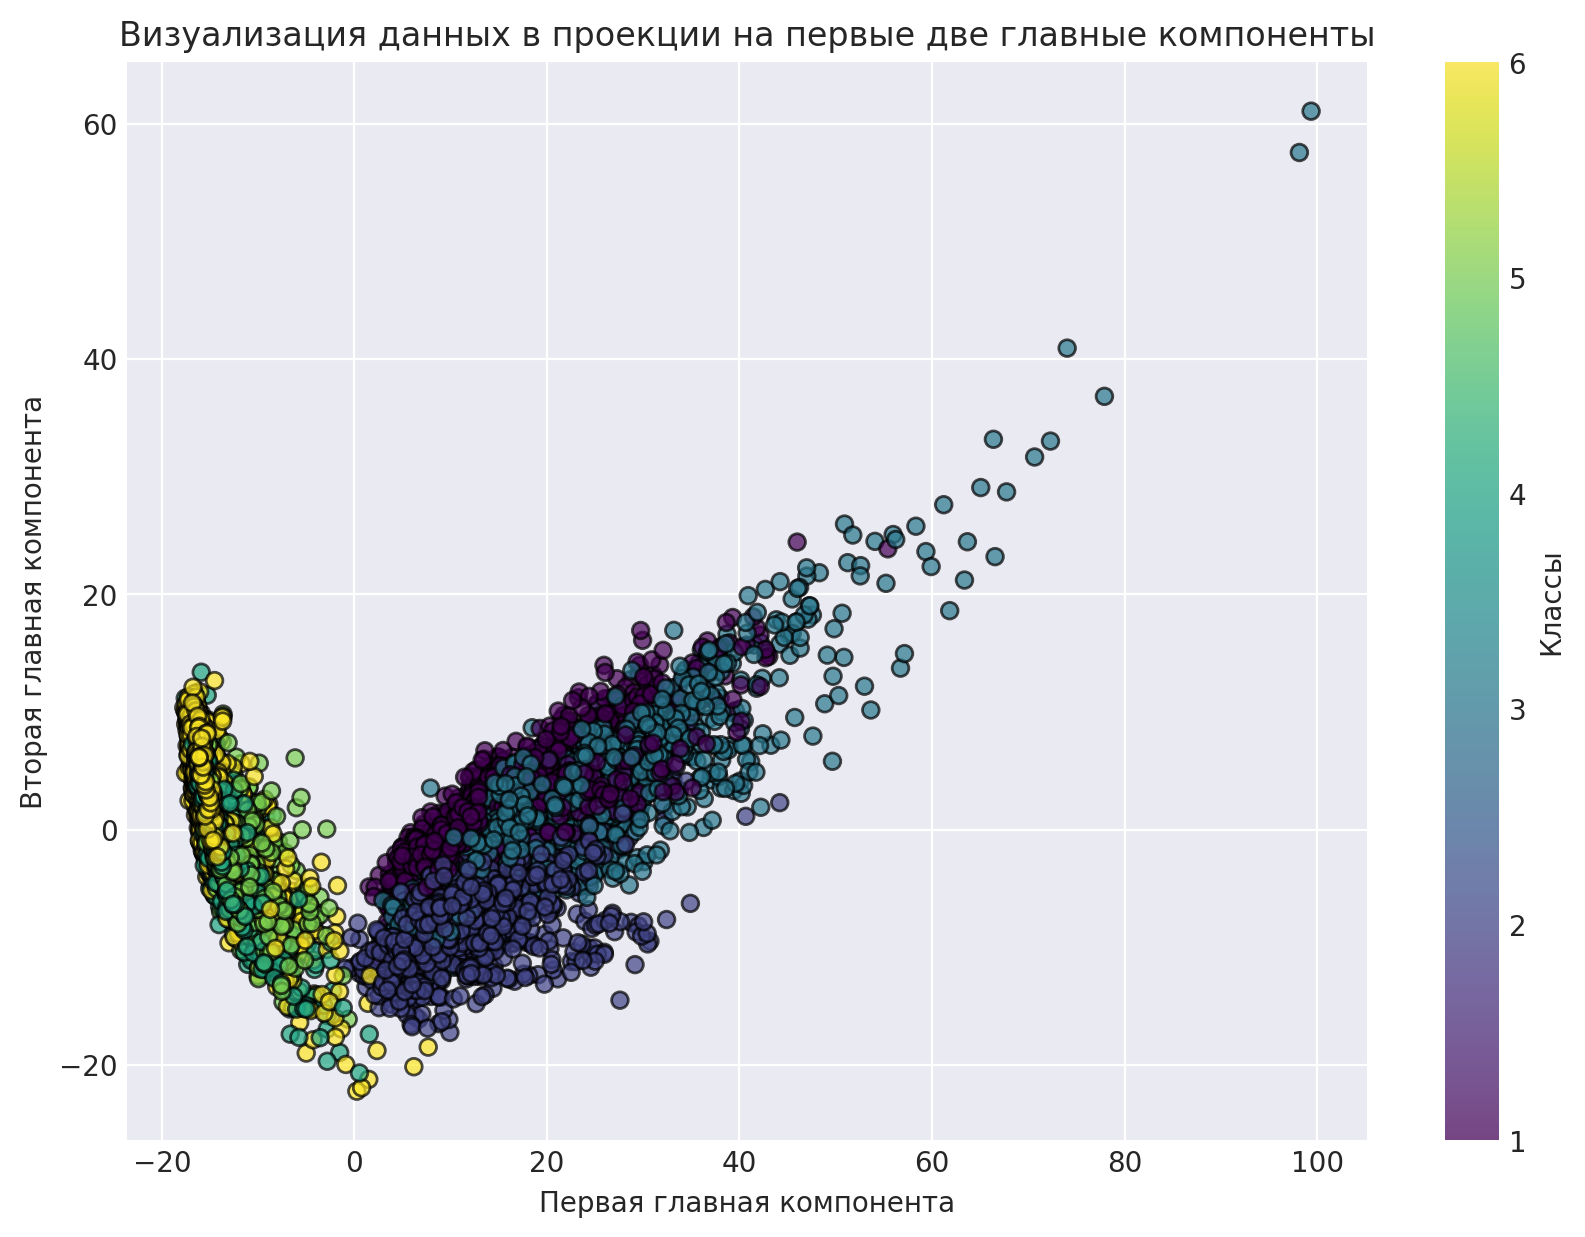

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Классы")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Визуализация данных в проекции на первые две главные компоненты")
plt.show()

Красиво. Но пока мало что понятно)

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
from sklearn.cluster import KMeans
start_train = time.time()
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
end_train = time.time()

In [ ]:
start_pred = time.time()
clusters = kmeans.predict(X_pca)
end_pred = time.time()

print(f"Время обучения KMeans: {end_train - start_train:.2f} секунд")
print(f"Время инференса KMeans: {end_pred - start_pred:.5f} секунд")

Время обучения KMeans: 9.58 секунд
Время инференса KMeans: 0.00511 секунд


Довольно быстро!

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

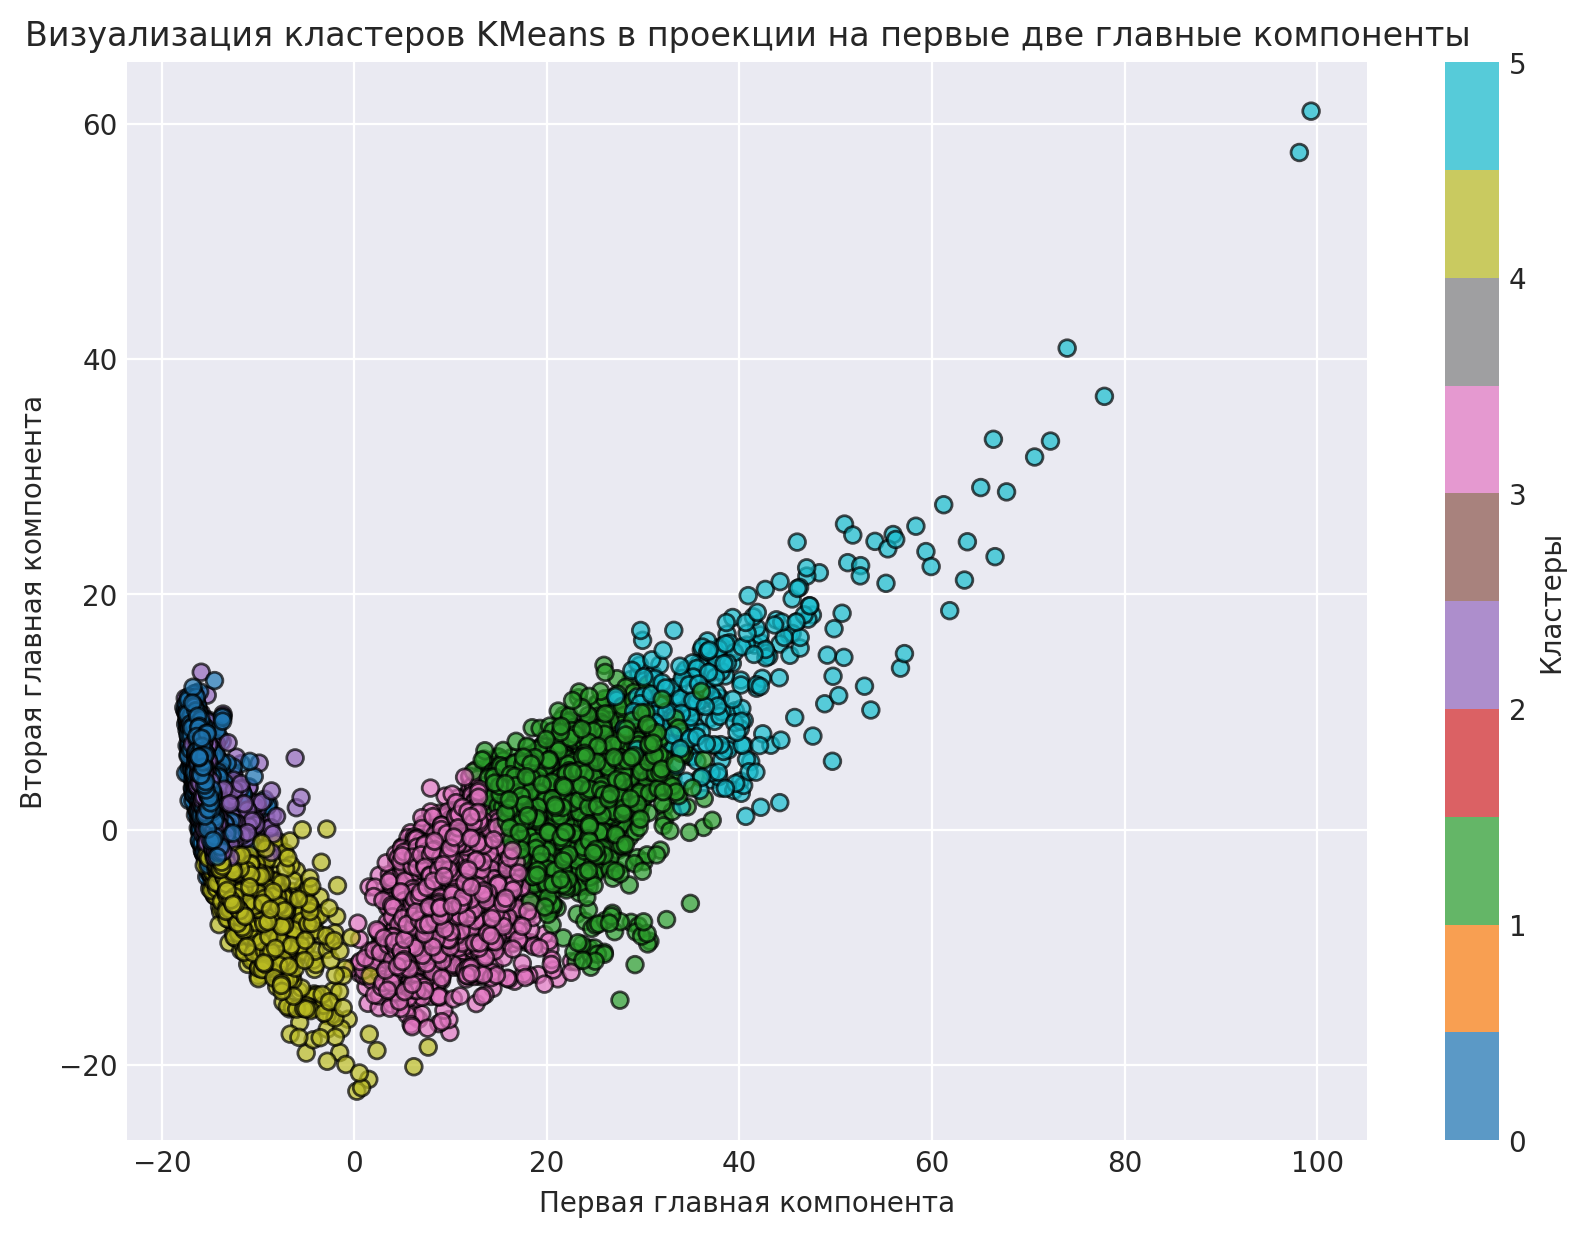

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Кластеры")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Визуализация кластеров KMeans в проекции на первые две главные компоненты")
plt.show()

О. Теперь красиво. Но видно почему-то 5 кластеров (правда, я плохо различаю цвета, так что норм).

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

Пожалуй, выберем Adjusted Rand Index (ARI) и Normalized Mutual Information (NMI), потому что у нас есть истинные метки классов, и эти метрики позволяют сравнить их с кластерами.  
ARI оценивает точность разбиения, учитывая совпадение пар объектов в одном кластере, а NMI измеряет информационное сходство между истинными классами и предсказанными кластерами. Они нормализованы и устойчивы к случайным разбиениям, что делает их удобными для оценки качества кластеризации.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari_score = adjusted_rand_score(y, clusters)
nmi_score = normalized_mutual_info_score(y, clusters)
print(f"ARI (Adjusted Rand Index): {ari_score:.4f}")
print(f"NMI (Normalized Mutual Information): {nmi_score:.4f}")

ARI (Adjusted Rand Index): 0.4195
NMI (Normalized Mutual Information): 0.5600


**Ваш вывод здесь**  
* ARI = 0.4195 - кластеры частично совпадают с истинными классами, но есть значительные ошибки.
* NMI = 0.5600 - кластеры содержат полезную информацию, но их структура не полностью отражает настоящие классы.

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
from sklearn.cluster import AgglomerativeClustering
start_train = time.time()
agg_clustering = AgglomerativeClustering(n_clusters=6)
clusters_agg = agg_clustering.fit_predict(X_pca)
end_train = time.time()

В AgglomerativeClustering предсказание делается сразу, засекать их не будем.

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agg, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(scatter, label="Кластеры Agglomerative")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("AgglomerativeClustering: Кластеры в проекции на первые две главные компоненты")
plt.show()

In [ ]:
ari_agg = adjusted_rand_score(y, clusters_agg)
nmi_agg = normalized_mutual_info_score(y, clusters_agg)

print(f"ARI (Agglomerative Clustering): {ari_agg:.4f}")
print(f"NMI (Agglomerative Clustering): {nmi_agg:.4f}")
print(f"Время обучения и инференса AgglomerativeClustering: {end_train - start_train:.2f} секунд")

ARI (Agglomerative Clustering): 0.4936
NMI (Agglomerative Clustering): 0.6218
Время обучения и инференса AgglomerativeClustering: 8.23 секунд


**Ваш вывод здесь**  
* Стало ли лучше? - Да, результаты Agglomerative Clustering лучше, чем у KMeans: ARI и NMI улучшились на 5-10%.
* Почему стало лучше?
1. Agglomerative Clustering — это иерархическая кластеризация, которая не зависит от начальной инициализации центроидов, как KMeans.
2. Этот метод лучше справляется с нелинейными структурами данных, поскольку строит дерево кластеров и объединяет близкие объекты на основе расстояний.
3. Время обучения дольше (8.23 сек), но это оправдано повышением качества кластеризации.

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**  
1. Похожи ли объекты внутри каждого кластера на определённый тип активности? - Да, кластеры различимы, вероятно, есть группы для динамических (ходьба, бег) и статических (сидение, стояние) активностей.
2. В каких кластерах смешано несколько типов активности? Почему? - Ходьба и бег могут пересекаться из-за схожих ускорений, сидение и стояние — из-за малых движений. Ошибки связаны с переходными состояниями.
3. Качественная ли получилась кластеризация? - Метрики (ARI = 0.4936, NMI = 0.6218) выше, чем у KMeans, но есть перекрытия классов. Улучшить можно через GMM, больше компонент PCA или учёт временных зависимостей.

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

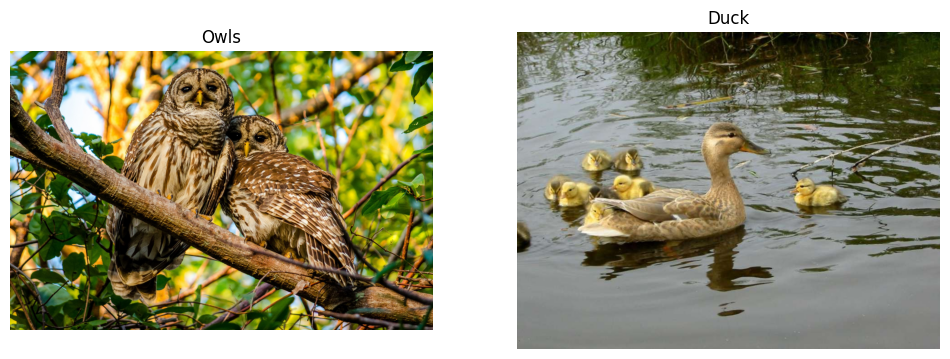

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

image_urls = {
    "Owls": "https://raw.githubusercontent.com/Murcha1990/ML_AI24/main/Hometasks/Pro/Owls.jpg",
    "Duck": "https://raw.githubusercontent.com/Murcha1990/ML_AI24/main/Hometasks/Pro/duck.jpg"
}
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (title, url) in zip(axes, image_urls.items()):
    response = requests.get(url)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content))

    ax.imshow(image)
    ax.set_title(title)
    ax.axis("off")

plt.show()

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    img_array = np.array(image)
    h, w, _ = img_array.shape
    X_pixels = np.zeros((h * w, 5))
    for i in range(h):
        for j in range(w):
            r, g, b = img_array[i, j]
            X_pixels[i * w + j] = [lmbd * (i / h), lmbd * (j / w), r, g, b]

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=777)
    labels = kmeans.fit_predict(X_pixels)
    clustered_img = kmeans.cluster_centers_[:, 2:].astype(int)[labels]
    segmented_img = clustered_img.reshape(h, w, 3)

    return segmented_img

response_duck = requests.get(image_urls["Duck"])
image_duck = Image.open(BytesIO(response_duck.content))

response_owls = requests.get(image_urls["Owls"])
image_owls = Image.open(BytesIO(response_owls.content))

Я не раз перезапускал эту часть ноутбука, поэтому импортируем бибиотеки заново тут

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

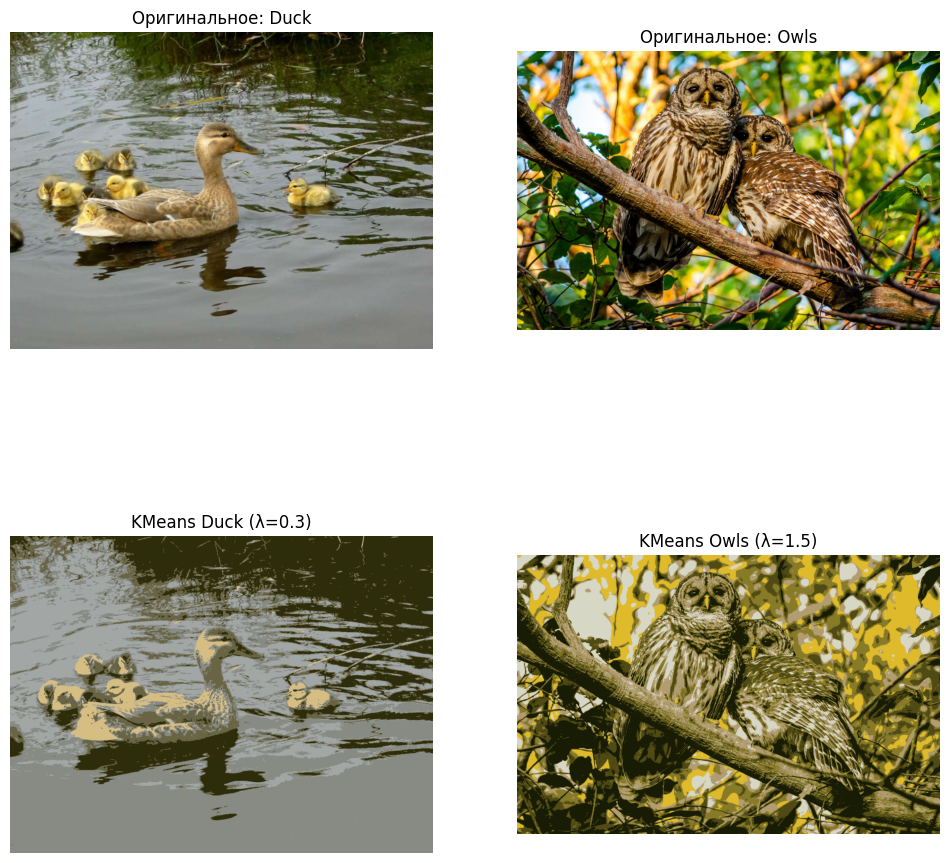

CPU times: user 48.6 s, sys: 6.18 s, total: 54.7 s
Wall time: 59 s


In [ ]:
%%time
lmbd_duck, lmbd_owls = 0.3, 1.5
n_clusters_duck, n_clusters_owls = 5, 6
seg_duck = find_components(image_duck, lmbd_duck, n_clusters_duck)
seg_owls = find_components(image_owls, lmbd_owls, n_clusters_owls)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(image_duck)
axes[0, 0].set_title("Оригинальное: Duck")
axes[0, 0].axis("off")

axes[0, 1].imshow(image_owls)
axes[0, 1].set_title("Оригинальное: Owls")
axes[0, 1].axis("off")

axes[1, 0].imshow(seg_duck)
axes[1, 0].set_title(f"KMeans Duck (λ={lmbd_duck})")
axes[1, 0].axis("off")

axes[1, 1].imshow(seg_owls)
axes[1, 1].set_title(f"KMeans Owls (λ={lmbd_owls})")
axes[1, 1].axis("off")

plt.show()

Вроде бы неплохо. Даже что-то видно.

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

Более трех часов выполнялось со сжатием в 2 раза, со сжатием в 8 раз переполняется оперативная память гугл колаба в 12 гб, так что давайте сожмем в 16 раз о_О

In [ ]:
%%time
from skimage import color, transform
from sklearn.cluster import SpectralClustering
def spectral_segmentation(image, n_clusters=3):
    img_gray = color.rgb2gray(np.array(image))
    img_resized = transform.resize(img_gray, (image.height // 16, image.width // 16), anti_aliasing=True)
    h, w = img_resized.shape
    X_pixels = img_resized.reshape(-1, 1)
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity="rbf",
        random_state=777,
        assign_labels="kmeans"
    )
    labels = spectral.fit_predict(X_pixels)
    segmented_img = labels.reshape(h, w)

    return segmented_img

seg_spectral_duck = spectral_segmentation(image_duck, n_clusters=3)
seg_spectral_owls = spectral_segmentation(image_owls, n_clusters=3)

CPU times: user 46.1 s, sys: 1.3 s, total: 47.4 s
Wall time: 32.5 s


Ох. Это было долго! Зато поняли, что spectral_segmentation - это не то, чем хочется пользоваться каждый день))

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(image_duck)
axes[0, 0].set_title("Оригинальное: Duck")
axes[0, 0].axis("off")

axes[0, 1].imshow(image_owls)
axes[0, 1].set_title("Оригинальное: Owls")
axes[0, 1].axis("off")

axes[1, 0].imshow(seg_spectral_duck, cmap="gray")
axes[1, 0].set_title("Spectral Clustering: Duck")
axes[1, 0].axis("off")

axes[1, 1].imshow(seg_spectral_owls, cmap="gray")
axes[1, 1].set_title("Spectral Clustering: Owls")
axes[1, 1].axis("off")

plt.show()

Ну что тут сказать. Белую уточку видно, ахах. А вот с совами едва различимы сами совы. Тут еще можно поколдовать, но дедлайн не дремлет...

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

Спасибо вам за задания. Было интересно!

Пусть будет снова кот Елены Кантонистовой)

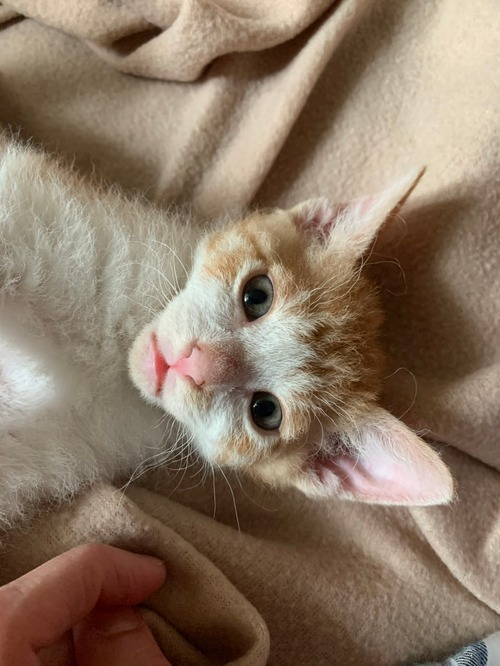